# Project 1

**Note**: if you feel like your Pandas skills need a bit of a touch up, check [this article out](https://levelup.gitconnected.com/20-pandas-functions-for-80-of-your-data-science-tasks-b610c8bfe63c)!

The dataset we're going to be using is one of the most realistic retail time-series datasets you'll find out there because, well, it's actual Walmart data. It was made available for a Kaggle competition that you can check out [here](https://www.kaggle.com/c/m5-forecasting-accuracy).

The original format of the data was in a "wide" format to made it smaller in memory, but that doesn't really work too well with databases and you won't see that very often in the real world. The most notable changes are that I added in a date column to replace the date identifier columns that were previously there, and I made the data smaller by only subsetting to the state of Texas.

**Another note:** If you want to develop and test your code with a smaller dataset (which I'd probably recommend), set `sampled` in the cell below to `True`. All of the tests will still pass if your code is correct!

Let's get into it!

In [41]:
# Setting the data directory appropriately
data_dir = '/kaggle/input/ts-forecasting-project-1-data/data'
sampled = False

path_suffix = '' if not sampled else '_sampled'

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

# Setting the Seaborn style to have a dark(ish) background with grid lines
sb.set_style('darkgrid')

## Getting our data in the right format

Time-series data has to be collected from some real-world, data-generating process. That means that raw data comes in as a series of observations. Depending on your experience with time-series data, you may be used to data that looks like this:

| Date       | Sales |
|------------|-------|
| 2022-01-01 |  23   |
| 2022-01-02 |  45   |
| 2022-01-03 |  12   |
| 2022-01-04 |  67   |
| 2022-01-05 |  89   |

But, if you're in retail, each of those "sales" probably came in some JSON from some point-of-sale system (i.e. cash register) that probably looked something like this:

```
{
    "timestamp": 2022-01-01 12:34:56,
    "product_id": 5,
    "store_id": 12,
    "category_id": 36,
    ...
}
```

Usually, it's the job of a data engineer to collect all of these records and aggregate them into a nice, tabular format, but it's worth at least having an appreciation for how it's done. So, we're going to start from a mock version of a transactions table.

In [43]:
transactions = pd.read_csv(f'{data_dir}/transactions_data{path_suffix}.csv')

transactions.head()

,date,id,item_id,dept_id,cat_id,store_id,state_id
0,2013-01-01 13:41:03,HOBBIES_1_004_TX_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,TX
1,2013-01-01 07:30:52,HOBBIES_1_004_TX_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,TX
2,2013-01-01 11:17:38,HOBBIES_1_004_TX_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,TX
3,2013-01-01 20:18:59,HOBBIES_1_025_TX_1_evaluation,HOBBIES_1_025,HOBBIES_1,HOBBIES,TX_1,TX
4,2013-01-01 21:36:09,HOBBIES_1_028_TX_1_evaluation,HOBBIES_1_028,HOBBIES_1,HOBBIES,TX_1,TX


In [44]:
transactions.dtypes

date        object
id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
state_id    object
dtype: object

You can see that this is a DataFrame where each row relates to purchases for an individual item. Here's a little data dictionary:

- `date`: the time at which an item was bought, down to the second
- `id`: the product ID. Each of these is an individual item at a specific store.
- `item_id`: this is an identifier for items, but not at the store level. You can use this to find the same item at different stores.
- `dept_id`: department ID. One level up from `item_id` in the hierarchy
- `cat_id`: category ID. One level up from `dept_id` in the hierarchy
- `store_id`: identifies the specific store where the product was bought
- `state_id`: identifies the specific state where the product was bought

`date` is supposed to be a `datetime`-like object, but you can see that when we loaded it from disk, it was loaded in as a string. Let's convert that column to `datetime`.

In [45]:
# QUESTION: Convert this column to a datetime object

# Converting the "date" feature to be a datetime object
transactions['date'] = pd.to_datetime(transactions['date'])

In [46]:
transactions.dtypes

date        datetime64[ns]
id                  object
item_id             object
dept_id             object
cat_id              object
store_id            object
state_id            object
dtype: object

Our goal is to transform this dataset into one that's easy to analyze and train models on. For this project, our goal is going to be to work at the daily level. So, our first step is to aggregate our transactions data up to the daily level.

To be more specific, this is what we want it to look like:

In [47]:
# This is a hefty table, so just peeking at the first 5 rows
pd.read_csv(f'{data_dir}/sales_data{path_suffix}.csv', nrows=5)

,date,id,item_id,dept_id,cat_id,store_id,state_id,sales
0,2013-01-01,HOBBIES_1_001_TX_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,0
1,2013-01-01,HOBBIES_1_002_TX_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,TX_1,TX,0
2,2013-01-01,HOBBIES_1_003_TX_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,TX_1,TX,0
3,2013-01-01,HOBBIES_1_004_TX_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,TX,3
4,2013-01-01,HOBBIES_1_005_TX_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,TX_1,TX,0


In [48]:
transactions.head()

,date,id,item_id,dept_id,cat_id,store_id,state_id
0,2013-01-01 13:41:03,HOBBIES_1_004_TX_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,TX
1,2013-01-01 07:30:52,HOBBIES_1_004_TX_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,TX
2,2013-01-01 11:17:38,HOBBIES_1_004_TX_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,TX
3,2013-01-01 20:18:59,HOBBIES_1_025_TX_1_evaluation,HOBBIES_1_025,HOBBIES_1,HOBBIES,TX_1,TX
4,2013-01-01 21:36:09,HOBBIES_1_028_TX_1_evaluation,HOBBIES_1_028,HOBBIES_1,HOBBIES,TX_1,TX


You can see that the `sales` column is really just a daily count of transactions for that particular `id`.

In the cell below, create a dataframe called `data`, which is the transactions dataframe aggregated to the daily level. It should look like the above, except you won't have zero sales days. Don't worry about order: the below test will handle that!

In [49]:
# Getting the counts of each group after grouping them by an aggregate date and ID (Note: I hate what I did here, but it works.)
data = transactions.groupby(by = [pd.Grouper(key = 'date', freq = 'D'), 'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']).size().reset_index()

# Renaming the feature holding the counts of each group from "0" to "sales"
data.rename(columns = {0: 'sales'}, inplace = True)

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3895938 entries, 0 to 3895937
Data columns (total 8 columns):
 #   Column    Dtype         
---  ------    -----         
 0   date      datetime64[ns]
 1   id        object        
 2   item_id   object        
 3   dept_id   object        
 4   cat_id    object        
 5   store_id  object        
 6   state_id  object        
 7   sales     int64         
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 237.8+ MB


If the cell below runs without error, you did it right!

In [51]:
def test_sales_eq(data):
    assert (
        pd.read_csv(f'{data_dir}/sales_data{path_suffix}.csv', usecols=['date', 'id', 'sales'])
        .assign(date=lambda df: pd.to_datetime(df.date))
        .query('sales != 0')
        .merge(data, on=['date', 'id'], how='left', suffixes=('_actual', '_predicted'))
        .fillna(0)
        .assign(sales_error=lambda df: (df.sales_actual - df.sales_predicted).abs())
        .sales_error
        .sum() < 1e-6
    ), 'Your version of sales does not match the original sales data.'

    assert (
        pd.read_csv(f'{data_dir}/sales_data{path_suffix}.csv', usecols=['date', 'id', 'sales'])
        .query('sales != 0')
        .shape[0]
    ) == data.shape[0], 'Your dataframe has a different number of rows than the original sales data.'

test_sales_eq(data)

## Optimizing our data

Let's take a look at how our data is being stored in memory.

In [52]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3895938 entries, 0 to 3895937
Data columns (total 8 columns):
 #   Column    Dtype         
---  ------    -----         
 0   date      datetime64[ns]
 1   id        object        
 2   item_id   object        
 3   dept_id   object        
 4   cat_id    object        
 5   store_id  object        
 6   state_id  object        
 7   sales     int64         
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 1.5 GB


1.5 GB of data for our purposed is certainly no joke. But how much of that is really necessary?

Most of our data is stored in the least memory efficient format for pandas: strings (objects). Let's fix that.

Hint: check out [this page](https://pandas.pydata.org/docs/user_guide/basics.html#basics-dtypes) of the pandas documentation that talks about data types.

In the below cell, convert the data types of columns to reduce memory usage as much as possible.

In [53]:
# Reassigning the datatypes for the string-fields to be of data type "category"
data = data.assign(
    id = data['id'].astype('category'),
    item_id = data['item_id'].astype('category'),
    dept_id = data['dept_id'].astype('category'),
    cat_id = data['cat_id'].astype('category'),
    store_id = data['store_id'].astype('category'),
    state_id = data['state_id'].astype('category')
)

In [54]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3895938 entries, 0 to 3895937
Data columns (total 8 columns):
 #   Column    Dtype         
---  ------    -----         
 0   date      datetime64[ns]
 1   id        category      
 2   item_id   category      
 3   dept_id   category      
 4   cat_id    category      
 5   store_id  category      
 6   state_id  category      
 7   sales     int64         
dtypes: category(6), datetime64[ns](1), int64(1)
memory usage: 90.4 MB


In my solution, I got the final DataFrame down to 90.4 MB, which is about 6% of the original size!

While we're at it, it's worth talking about the best way to store this data on disk. If we saved this as a CSV, it wouldn't maintain any of the data type modifications we just made. Pandas offers a bunch of options for saving DataFrames, but here are the two I'd recommend:

- [Parquet](https://pandas.pydata.org/docs/dev/reference/api/pandas.DataFrame.to_parquet.html) has basically become the industry standard for storing tabular data on disk. It's a columnar file format that automatically compresses your data (which it does really well) and will maintain any data types you use in Pandas, with only a couple exceptions.

- [Feather](https://pandas.pydata.org/docs/dev/reference/api/pandas.DataFrame.to_parquet.html) is also a columnar data format, but it optimizes heavily for read speed. Your file size will be much bigger than Parquets, but it's really useful when you need to heavily optimize for data reading.

In [55]:
data.to_parquet('sales_data_checkpoint.parquet')

In [56]:
data = pd.read_parquet('sales_data_checkpoint.parquet')

In [57]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3895938 entries, 0 to 3895937
Data columns (total 8 columns):
 #   Column    Dtype         
---  ------    -----         
 0   date      datetime64[ns]
 1   id        category      
 2   item_id   category      
 3   dept_id   category      
 4   cat_id    category      
 5   store_id  category      
 6   state_id  category      
 7   sales     int64         
dtypes: category(6), datetime64[ns](1), int64(1)
memory usage: 90.4 MB


On my local machine, loading our original CSV took ~8.7 seconds, and that only took 0.1 seconds. And our data types were maintained! Nice!

## Finishing up our data pre-processing

There's one last modification we need to make to our data before it's ready to go. The way that we converted transactions into sales was *slightly* problematic because now, when a product doesn't sell it just isn't present in our data, rather than appearing as a zero. 

That's an issue for our forecasting models, so let's fix it!

First, set your index to columns that the DataFrame is distinct on (`date` and `id`).

In [58]:
# Setting the index based on the "date" and "id" features
data = data.set_index(keys = ['date', 'id'])

Now, create a MultiIndex with all combinations of daily dates and `id`s using `pd.MultiIndex.from_product`

In [59]:
# Your code here

# Getting the unique values from each the respective "date" and "id" features
unique_dates = data.index.get_level_values('date').unique()
unique_ids = data.index.get_level_values('id').unique()

# Creating a MultiIndex from the product of the unique dates and IDs
index_to_select = pd.MultiIndex.from_product([unique_dates, unique_ids], names = ['date', 'id'])

Finally, fill the resulting `NaN`s in your dataframe. Hint: it's tempting to use `.groupby().fillna(method='ffill')` (and backfilling), but unfortunately this method is quite slow on grouped data. I'd recommend manually recreating the categorical columns by splitting the `id` column on underscores. This cell could take over a minute to run depending on how you implement it!

In [60]:
## NOTE: I'm separating all these cells because it helps me to see the output of what I'm working with to know if I'm on the right track. :)

# Re-indexing the data using the MultiIndex produced in the previous cell
data = data.reindex(index_to_select)
data

item_id  dept_id cat_id store_id  \
date       id                                                                  
2013-01-01 FOODS_1_004_TX_1_evaluation  FOODS_1_004  FOODS_1  FOODS     TX_1   
           FOODS_1_004_TX_2_evaluation  FOODS_1_004  FOODS_1  FOODS     TX_2   
           FOODS_1_004_TX_3_evaluation  FOODS_1_004  FOODS_1  FOODS     TX_3   
           FOODS_1_005_TX_2_evaluation  FOODS_1_005  FOODS_1  FOODS     TX_2   
           FOODS_1_009_TX_2_evaluation  FOODS_1_009  FOODS_1  FOODS     TX_2   
...                                             ...      ...    ...      ...   
2016-05-22 FOODS_2_117_TX_1_evaluation          NaN      NaN    NaN      NaN   
           FOODS_2_256_TX_3_evaluation  FOODS_2_256  FOODS_2  FOODS     TX_3   
           FOODS_2_256_TX_1_evaluation          NaN      NaN    NaN      NaN   
           FOODS_3_296_TX_2_evaluation  FOODS_3_296  FOODS_3  FOODS     TX_2   
           FOODS_2_069_TX_3_evaluation          NaN      NaN    NaN      NaN   

                                       state_id  sales  
date       id                                           
2013-01-01 FOODS_1_004_TX_1_evaluation       TX   20.0  
           FOODS_1_004_TX_2_evaluation       TX   20.0  
           FOODS_1_004_TX_3_evaluation       TX    4.0  
           FOODS_1_005_TX_2_evaluation       TX    1.0  
           FOODS_1_009_TX_2_evaluation       TX    3.0  
...                                         ...    ...  
2016-05-22 FOODS_2_117_TX_1_evaluation      NaN    NaN  
           FOODS_2_256_TX_3_evaluation       TX    1.0  
           FOODS_2_256_TX_1_evaluation      NaN    NaN  
           FOODS_3_296_TX_2_evaluation       TX    3.0  
           FOODS_2_069_TX_3_evaluation      NaN    NaN  

[11322748 rows x 6 columns]

In [61]:
# Obtaining the null rows from the dataset
data_nulls = data[data['sales'].isna()]
data_nulls

item_id dept_id cat_id store_id  \
date       id                                                            
2013-01-01 FOODS_1_003_TX_2_evaluation     NaN     NaN    NaN      NaN   
           FOODS_1_005_TX_1_evaluation     NaN     NaN    NaN      NaN   
           FOODS_1_009_TX_3_evaluation     NaN     NaN    NaN      NaN   
           FOODS_1_010_TX_3_evaluation     NaN     NaN    NaN      NaN   
           FOODS_1_012_TX_3_evaluation     NaN     NaN    NaN      NaN   
...                                        ...     ...    ...      ...   
2016-05-22 FOODS_2_117_TX_2_evaluation     NaN     NaN    NaN      NaN   
           FOODS_2_209_TX_3_evaluation     NaN     NaN    NaN      NaN   
           FOODS_2_117_TX_1_evaluation     NaN     NaN    NaN      NaN   
           FOODS_2_256_TX_1_evaluation     NaN     NaN    NaN      NaN   
           FOODS_2_069_TX_3_evaluation     NaN     NaN    NaN      NaN   

                                       state_id  sales  
date       id                                           
2013-01-01 FOODS_1_003_TX_2_evaluation      NaN    NaN  
           FOODS_1_005_TX_1_evaluation      NaN    NaN  
           FOODS_1_009_TX_3_evaluation      NaN    NaN  
           FOODS_1_010_TX_3_evaluation      NaN    NaN  
           FOODS_1_012_TX_3_evaluation      NaN    NaN  
...                                         ...    ...  
2016-05-22 FOODS_2_117_TX_2_evaluation      NaN    NaN  
           FOODS_2_209_TX_3_evaluation      NaN    NaN  
           FOODS_2_117_TX_1_evaluation      NaN    NaN  
           FOODS_2_256_TX_1_evaluation      NaN    NaN  
           FOODS_2_069_TX_3_evaluation      NaN    NaN  

[7426810 rows x 6 columns]

In [62]:
# Setting the nulls of the sales column to be zero
data_nulls['sales'] = 0
data_nulls

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


item_id dept_id cat_id store_id  \
date       id                                                            
2013-01-01 FOODS_1_003_TX_2_evaluation     NaN     NaN    NaN      NaN   
           FOODS_1_005_TX_1_evaluation     NaN     NaN    NaN      NaN   
           FOODS_1_009_TX_3_evaluation     NaN     NaN    NaN      NaN   
           FOODS_1_010_TX_3_evaluation     NaN     NaN    NaN      NaN   
           FOODS_1_012_TX_3_evaluation     NaN     NaN    NaN      NaN   
...                                        ...     ...    ...      ...   
2016-05-22 FOODS_2_117_TX_2_evaluation     NaN     NaN    NaN      NaN   
           FOODS_2_209_TX_3_evaluation     NaN     NaN    NaN      NaN   
           FOODS_2_117_TX_1_evaluation     NaN     NaN    NaN      NaN   
           FOODS_2_256_TX_1_evaluation     NaN     NaN    NaN      NaN   
           FOODS_2_069_TX_3_evaluation     NaN     NaN    NaN      NaN   

                                       state_id  sales  
date       id                                           
2013-01-01 FOODS_1_003_TX_2_evaluation      NaN      0  
           FOODS_1_005_TX_1_evaluation      NaN      0  
           FOODS_1_009_TX_3_evaluation      NaN      0  
           FOODS_1_010_TX_3_evaluation      NaN      0  
           FOODS_1_012_TX_3_evaluation      NaN      0  
...                                         ...    ...  
2016-05-22 FOODS_2_117_TX_2_evaluation      NaN      0  
           FOODS_2_209_TX_3_evaluation      NaN      0  
           FOODS_2_117_TX_1_evaluation      NaN      0  
           FOODS_2_256_TX_1_evaluation      NaN      0  
           FOODS_2_069_TX_3_evaluation      NaN      0  

[7426810 rows x 6 columns]

In [63]:
# Collecting the IDs associated to the null records and splitting them on the underscore while 
null_ids = pd.DataFrame(data = data_nulls.index.get_level_values('id').str.split('_').tolist(),
                        index = data_nulls.index)
null_ids

0  1    2   3  4           5
date       id                                                           
2013-01-01 FOODS_1_003_TX_2_evaluation  FOODS  1  003  TX  2  evaluation
           FOODS_1_005_TX_1_evaluation  FOODS  1  005  TX  1  evaluation
           FOODS_1_009_TX_3_evaluation  FOODS  1  009  TX  3  evaluation
           FOODS_1_010_TX_3_evaluation  FOODS  1  010  TX  3  evaluation
           FOODS_1_012_TX_3_evaluation  FOODS  1  012  TX  3  evaluation
...                                       ... ..  ...  .. ..         ...
2016-05-22 FOODS_2_117_TX_2_evaluation  FOODS  2  117  TX  2  evaluation
           FOODS_2_209_TX_3_evaluation  FOODS  2  209  TX  3  evaluation
           FOODS_2_117_TX_1_evaluation  FOODS  2  117  TX  1  evaluation
           FOODS_2_256_TX_1_evaluation  FOODS  2  256  TX  1  evaluation
           FOODS_2_069_TX_3_evaluation  FOODS  2  069  TX  3  evaluation

[7426810 rows x 6 columns]

In [64]:
# Extracting the respective pieces of information from the null IDs
item_ids  = null_ids[0] + '_' + null_ids[1] + '_' + null_ids[2]
dept_ids  = null_ids[0] + '_' + null_ids[1]
cat_ids   = null_ids[0]
store_ids = null_ids[3] + '_' + null_ids[4]
state_ids = null_ids[3]

# Viewing just the item_ids for verification
item_ids

date        id                         
2013-01-01  FOODS_1_003_TX_2_evaluation    FOODS_1_003
            FOODS_1_005_TX_1_evaluation    FOODS_1_005
            FOODS_1_009_TX_3_evaluation    FOODS_1_009
            FOODS_1_010_TX_3_evaluation    FOODS_1_010
            FOODS_1_012_TX_3_evaluation    FOODS_1_012
                                              ...     
2016-05-22  FOODS_2_117_TX_2_evaluation    FOODS_2_117
            FOODS_2_209_TX_3_evaluation    FOODS_2_209
            FOODS_2_117_TX_1_evaluation    FOODS_2_117
            FOODS_2_256_TX_1_evaluation    FOODS_2_256
            FOODS_2_069_TX_3_evaluation    FOODS_2_069
Length: 7426810, dtype: object

In [65]:
# Updating the original full "data" dataframe with all the appropriate null values
data['sales'].update(data_nulls['sales'])
data['item_id'].update(item_ids)
data['dept_id'].update(dept_ids)
data['cat_id'].update(cat_ids)
data['store_id'].update(store_ids)
data['state_id'].update(state_ids)

data

item_id  dept_id cat_id store_id  \
date       id                                                                  
2013-01-01 FOODS_1_004_TX_1_evaluation  FOODS_1_004  FOODS_1  FOODS     TX_1   
           FOODS_1_004_TX_2_evaluation  FOODS_1_004  FOODS_1  FOODS     TX_2   
           FOODS_1_004_TX_3_evaluation  FOODS_1_004  FOODS_1  FOODS     TX_3   
           FOODS_1_005_TX_2_evaluation  FOODS_1_005  FOODS_1  FOODS     TX_2   
           FOODS_1_009_TX_2_evaluation  FOODS_1_009  FOODS_1  FOODS     TX_2   
...                                             ...      ...    ...      ...   
2016-05-22 FOODS_2_117_TX_1_evaluation  FOODS_2_117  FOODS_2  FOODS     TX_1   
           FOODS_2_256_TX_3_evaluation  FOODS_2_256  FOODS_2  FOODS     TX_3   
           FOODS_2_256_TX_1_evaluation  FOODS_2_256  FOODS_2  FOODS     TX_1   
           FOODS_3_296_TX_2_evaluation  FOODS_3_296  FOODS_3  FOODS     TX_2   
           FOODS_2_069_TX_3_evaluation  FOODS_2_069  FOODS_2  FOODS     TX_3   

                                       state_id  sales  
date       id                                           
2013-01-01 FOODS_1_004_TX_1_evaluation       TX   20.0  
           FOODS_1_004_TX_2_evaluation       TX   20.0  
           FOODS_1_004_TX_3_evaluation       TX    4.0  
           FOODS_1_005_TX_2_evaluation       TX    1.0  
           FOODS_1_009_TX_2_evaluation       TX    3.0  
...                                         ...    ...  
2016-05-22 FOODS_2_117_TX_1_evaluation       TX    0.0  
           FOODS_2_256_TX_3_evaluation       TX    1.0  
           FOODS_2_256_TX_1_evaluation       TX    0.0  
           FOODS_3_296_TX_2_evaluation       TX    3.0  
           FOODS_2_069_TX_3_evaluation       TX    0.0  

[11322748 rows x 6 columns]

In [66]:
data.isna().sum()

item_id     0
dept_id     0
cat_id      0
store_id    0
state_id    0
sales       0
dtype: int64

In [67]:
def test_sales_eq(data):
    assert (
        pd.read_csv(f'{data_dir}/sales_data{path_suffix}.csv', usecols=['date', 'id', 'sales'])
        .assign(date=lambda df: pd.to_datetime(df.date))
        .merge(data, on=['date', 'id'], how='left', suffixes=('_actual', '_predicted'))
        #.fillna(0)
        .assign(sales_error=lambda df: (df.sales_actual - df.sales_predicted).abs())
        .sales_error
        .sum() < 1e-6
    ), 'Your version of sales does not match the original sales data.'

test_sales_eq(data)

## Exploring our data

Exploratory data analysis is crucial for building the best models.

Before you start this section, though, I would **highly recommend** that you set the index of your DataFrame to be on both the `date` and `id` field (our DataFrame has one row for each `date`/`id` combo). It's up to you, but it's good practice!

For this section, find 3-5 insights about the data that you feel are helpful for building models. Specifically, we'll be building models at the `date`/`dept_id` level (i.e., a forecast for `FOODS_1` on 2011-02-01, 2011-02-02, etc., a forecast for `HOBBIES_1` on 2011-02-01, 2011-02-02, etc.)

The only required one is an [autocorrelation analysis](https://pandas.pydata.org/docs/reference/api/pandas.plotting.autocorrelation_plot.html). Other than that, some ideas are:

- Looking for seasonal patterns and trends for each department
- Department sales by day of week
- Analyses at a higher level, like the category level

Anything goes! Be creative!

Here's an example of plotting the category-level sales for `FOODS_1` to get you started:

```
(
    data
    .groupby(['date', 'dept_id'])
    .sales
    .sum()
    [:, 'FOODS_1']
    .plot()
)
```

In [68]:
# Grouping the data by date and department ID and summing up the sales
df_depts = data.groupby(by = ['date', 'dept_id'])['sales'].sum()
df_depts

date        dept_id    
2013-01-01  FOODS_1         727.0
            FOODS_2         892.0
            FOODS_3        4230.0
            HOBBIES_1       412.0
            HOBBIES_2        37.0
                            ...  
2016-05-22  FOODS_3        7110.0
            HOBBIES_1      1362.0
            HOBBIES_2       181.0
            HOUSEHOLD_1    3018.0
            HOUSEHOLD_2     754.0
Name: sales, Length: 8666, dtype: float64

In [69]:
# Getting the unique department IDs
all_depts = data['dept_id'].unique()
print(all_depts)
print(len(all_depts))

['FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2']
Categories (7, object): ['FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2']
7


IndexError: index 2 is out of bounds for axis 1 with size 2

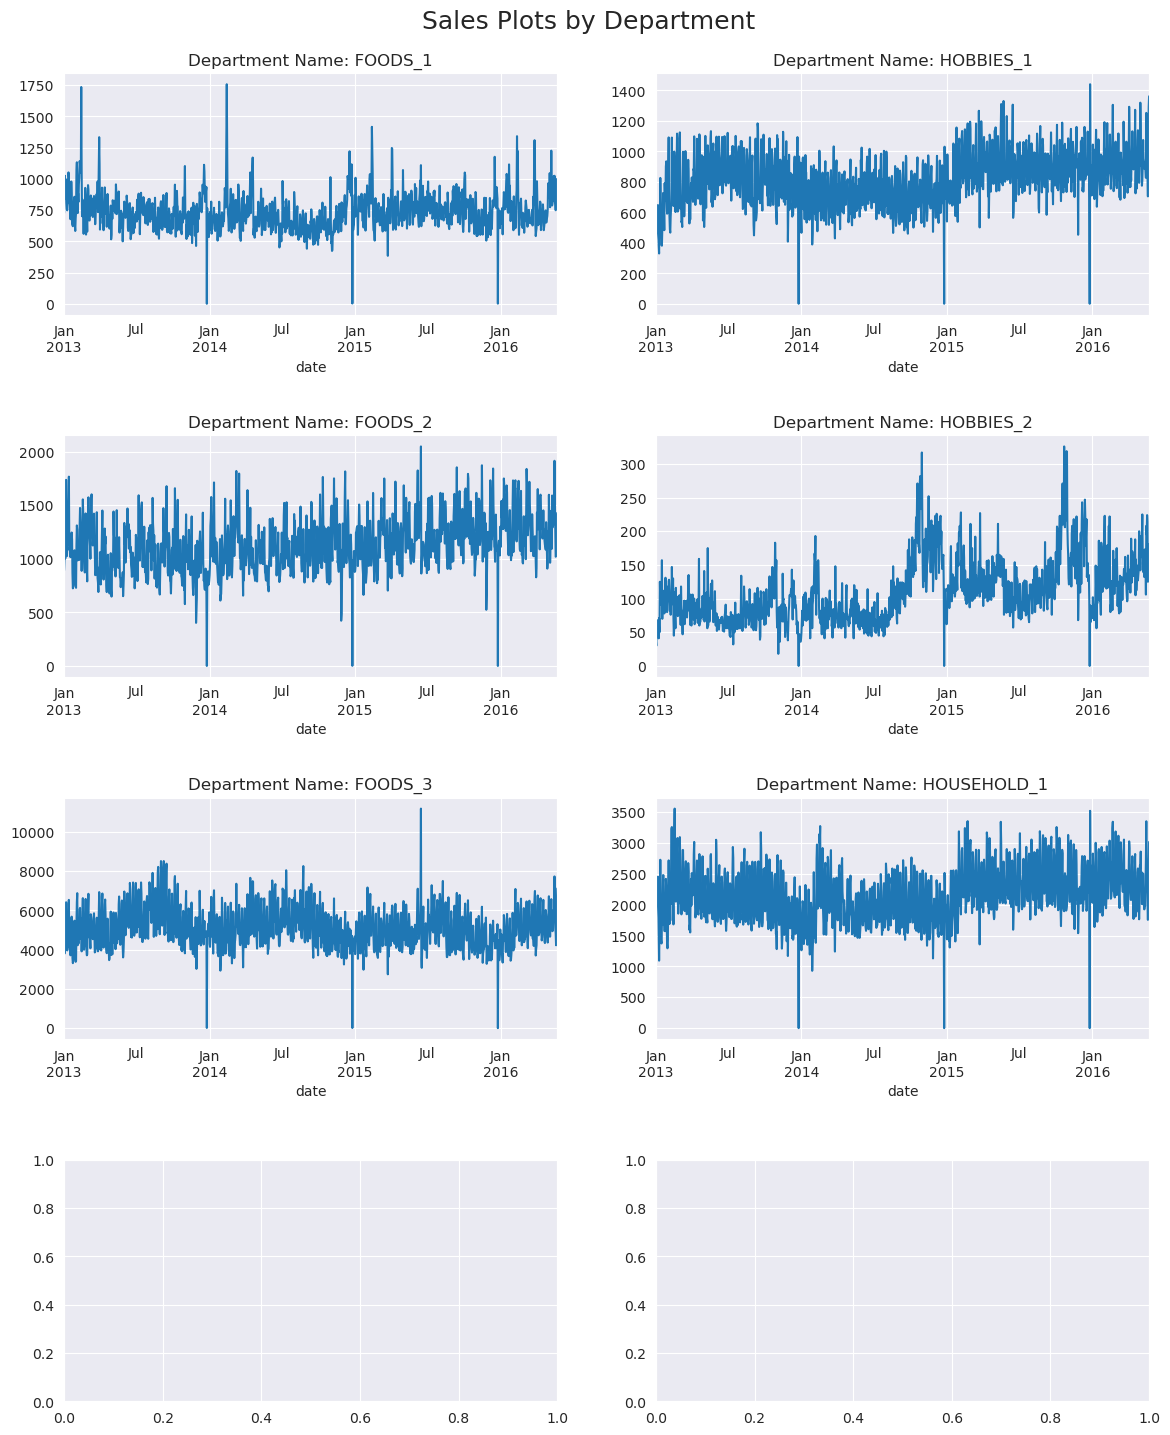

In [71]:
# Establishing a 3x2 grid for our plots
figure, axes = plt.subplots(4, 2, figsize = (14, 16))

# Adjusting the space between the plots
figure.subplots_adjust(hspace = 0.5, wspace = 0.2)

# Adding a title to the collective figure
figure.suptitle('Sales Plots by Department', fontsize = 18)
figure.subplots_adjust(top = .94)

# Establishing x- and y-coordinate values
x_coord, y_coord = 0, 0

# Displaying all the plots for each respective department
for dept in all_depts:
    
    # Plotting the chart for the respective diagram
    df_depts[:, dept].plot(ax = axes[x_coord, y_coord], title = f'Department Name: {dept}')
    
    # Incrementing the coordinates appropriately
    x_coord += 1
    if x_coord == 3:
        y_coord += 1
        x_coord = 0

In [72]:
# Grouping the data by date and category ID and summing up the sales
df_cats = data.groupby(by = ['date', 'cat_id'])['sales'].sum()
df_cats

date        cat_id   
2013-01-01  FOODS        5849.0
            HOBBIES       449.0
            HOUSEHOLD    2036.0
2013-01-02  FOODS        5597.0
            HOBBIES       492.0
                          ...  
2016-05-21  HOBBIES      1440.0
            HOUSEHOLD    3407.0
2016-05-22  FOODS        9500.0
            HOBBIES      1543.0
            HOUSEHOLD    3772.0
Name: sales, Length: 3714, dtype: float64

In [73]:
# Getting the unique category IDs
all_cats = data['cat_id'].unique()
print(all_cats)
print(len(all_cats))

['FOODS', 'HOBBIES', 'HOUSEHOLD']
Categories (3, object): ['FOODS', 'HOBBIES', 'HOUSEHOLD']
3


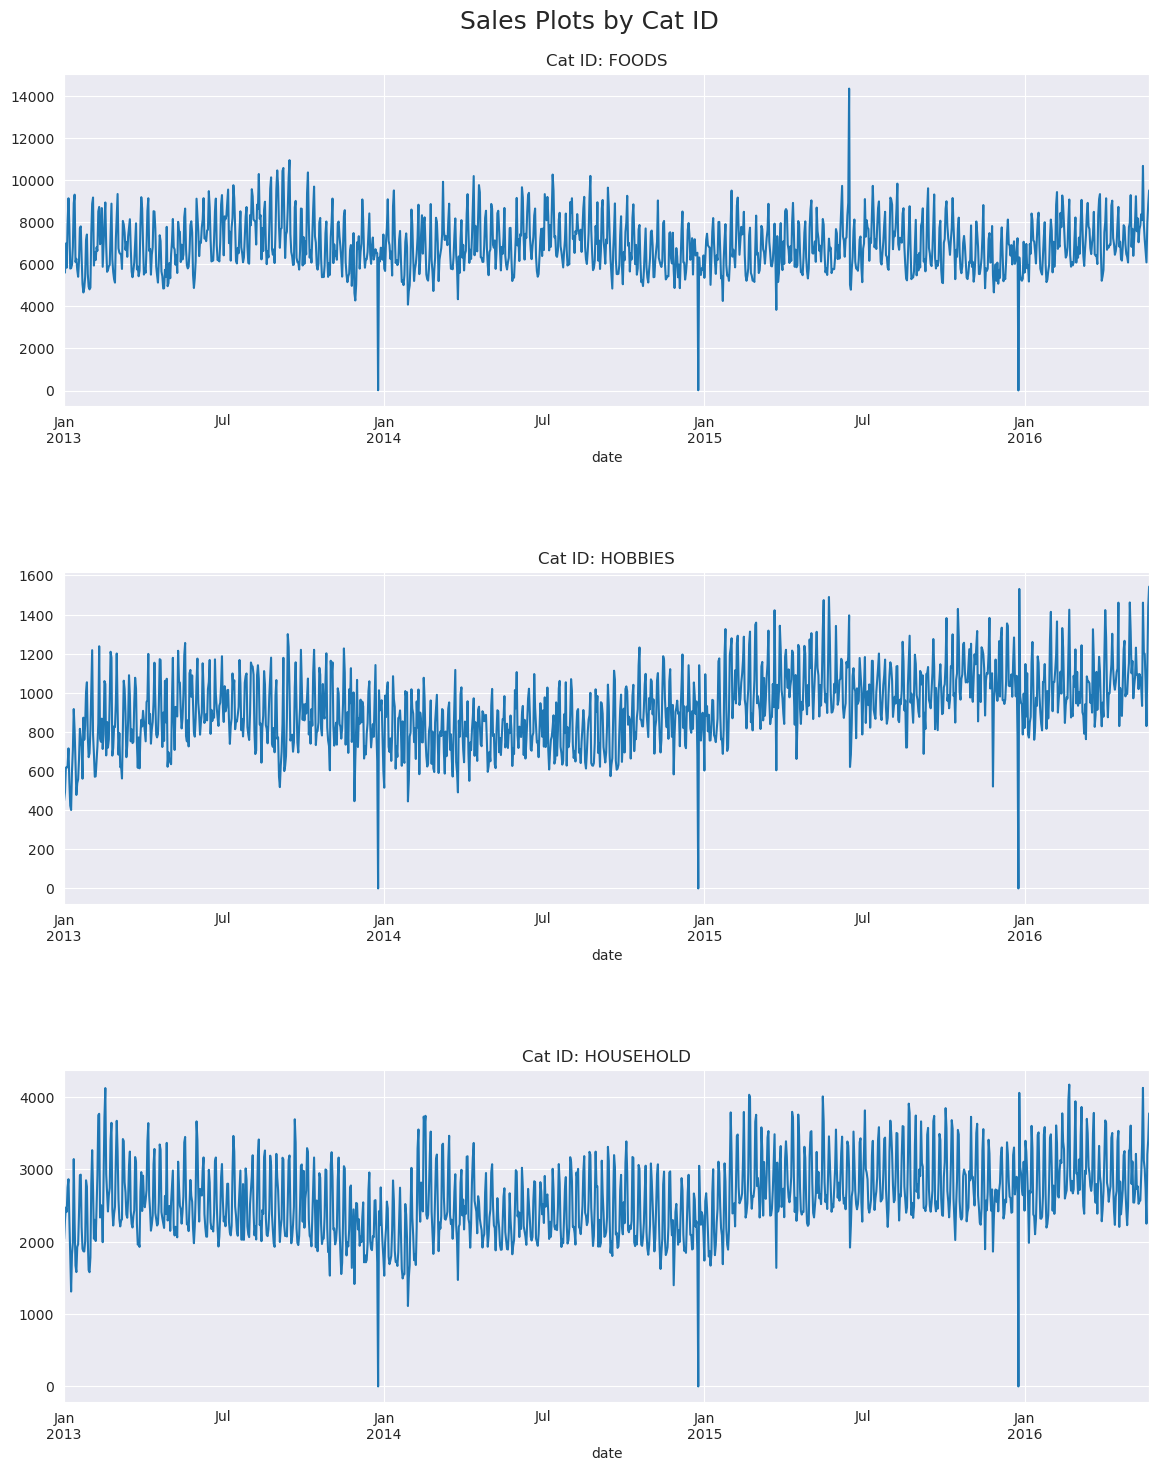

In [74]:
# Establishing a 1x2 grid for our plots
figure, axes = plt.subplots(3, 1, figsize = (14, 16))

# Adjusting the space between the plots
figure.subplots_adjust(hspace = 0.5)

# Adding a title to the collective figure
figure.suptitle('Sales Plots by Cat ID', fontsize = 18)
figure.subplots_adjust(top = .94)

# Establishing x- and y-coordinate values
x_coord, y_coord = 0, 0

# Displaying all the plots for each respective department
for cat in all_cats:
    
    # Plotting the chart for the respective diagram
    df_cats[:, cat].plot(ax = axes[y_coord], title = f'Cat ID: {cat}')
    
    # Incrementing the coordinates appropriately
    y_coord += 1

IndexError: index 2 is out of bounds for axis 1 with size 2

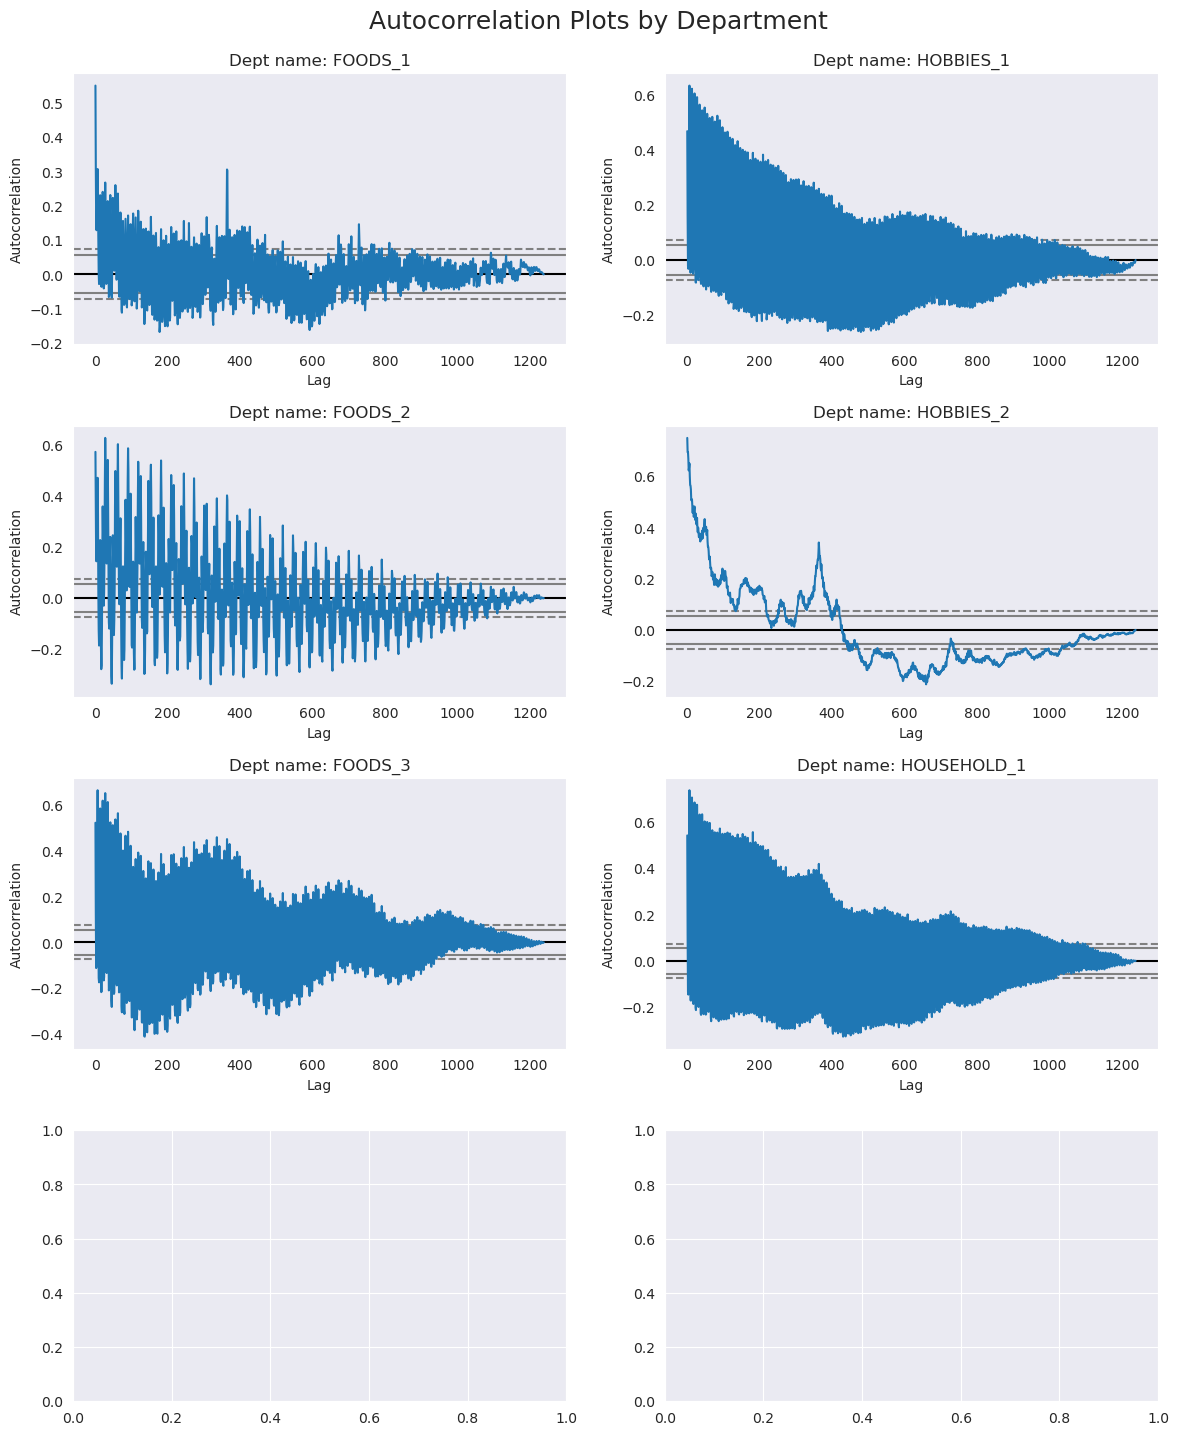

In [75]:
# Establishing a 3x2 grid for our plots
figure, axes = plt.subplots(4, 2, figsize = (14, 16))

# Adjusting the space between the plots
figure.subplots_adjust(hspace = 0.3, wspace = 0.2)

# Adding a title to the collective figure
figure.suptitle('Autocorrelation Plots by Department', fontsize = 18)
figure.subplots_adjust(top = .94)

# Establishing x- and y-coordinate values
x_coord, y_coord = 0, 0

# Displaying all the plots for each respective department
for dept in all_depts:
    
    # Plotting the chart for the respective diagram
    pd.plotting.autocorrelation_plot(df_depts[:, dept], ax = axes[x_coord, y_coord])
    
    # Setting the title for the subplot
    axes[x_coord, y_coord].set_title(f'Dept name: {dept}')
    
    # Incrementing the coordinates appropriately
    x_coord += 1
    if x_coord == 3:
        y_coord += 1
        x_coord = 0

## Training some models!

Finally, we can train some models!

We're going to use the [statsforecast](https://github.com/Nixtla/statsforecast) library, since it makes training statistical time-series models really easy. There are other great libraries (like [darts](https://unit8co.github.io/darts/), which is more mature of a package) but I like `statsforecast` a bit more for these models. Eventually, we'll get to training our own models from scratch.

Here's what you need to do:

1. Aggregate sales up to the `date`/`dept_id` level so each date has 7 distinct records (one for each `dept_id`).
2. Convert your aggregated data into the [format that `statsforecast` likes](https://nixtla.github.io/statsforecast/examples/getting_started_short.html).
3. Fit and evaluate some models! This part is made straightforward by `statsforecast` so feel free to fit whatever you want, but focus on models like [this one](https://nixtla.github.io/statsforecast/models.html#arima-family) and [this one](https://nixtla.github.io/statsforecast/models.html#holt-winters-method) since we discussed them. Their documentation has a [quickstart](https://nixtla.github.io/statsforecast/examples/getting_started_short.html) to get going. I provided you with some helper code below to get started.
    - Play around with `ARIMA` and `HoltWinters` and tune them using your intution, then compare them to [`AutoARIMA`](https://nixtla.github.io/statsforecast/models.html#autoarima) and [`AutoETS`](https://nixtla.github.io/statsforecast/models.html#autoets), which do the tuning for you!
4. (If your time permits) try out other libraries! Go try to fit a [Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api) model, fit some models using `darts` and see how they compare, etc.

In [76]:
# You'll see a lot of "WARNING: Retrying" outputs if you don't have internet enabled
# This happens because you haven't verified your phone number for your Kaggle profile.
# To do that, you'll need to exit the notebook, go to your profile, go to "account", and verify your phone number.
# Other than that, don't worry about any error outputs you see from this
! pip install statsforecast==1.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.8/187.8 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 63.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.1/185.1 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 12.9 MB/s eta 0:00:00
     ━

In [77]:
from statsforecast import StatsForecast
from statsforecast.models import ARIMA, HoltWinters

/opt/conda/lib/python3.7/site-packages/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [78]:
# Aggregate data to date/dept_id level

train_data = data.groupby(['date', 'dept_id']).sales.agg('sum').reset_index()
train_data.head()

,date,dept_id,sales
0,2013-01-01,FOODS_1,727.0
1,2013-01-01,FOODS_2,892.0
2,2013-01-01,FOODS_3,4230.0
3,2013-01-01,HOBBIES_1,412.0
4,2013-01-01,HOBBIES_2,37.0


In [79]:
df = train_data.rename(columns={
    'dept_id': 'unique_id',
    'date': 'ds',
    'sales': 'y'
})
train_df = df[df.ds < pd.Timestamp('2016-04-24')]

sf = StatsForecast(
    models=[
        # SARIMA(1, 1, 1)(1, 1, 1),7
        ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1), season_length=7),
        # ETS model
        HoltWinters(season_length=7)
    ],
    freq='D'
)
sf.fit(train_df)

StatsForecast(models=[ARIMA,HoltWinters])

In [80]:
forecast_df = sf.predict(h=28)
forecast_df.tail()

,ds,ARIMA,HoltWinters
unique_id,,,
HOUSEHOLD_2,2016-05-17,503.164734,504.839935
HOUSEHOLD_2,2016-05-18,508.078461,508.097931
HOUSEHOLD_2,2016-05-19,527.373230,521.676636
HOUSEHOLD_2,2016-05-20,554.838684,564.961609
HOUSEHOLD_2,2016-05-21,680.278992,669.920959


These are `plotly` charts, which are interactive. If you're not familiar, you can:
- Click a series name in the legend (on the right) to activate/deactivate it in the plots
- Hover your mouse over the plots and click + drag to zoom in
- Double click on the plots to zoom back out

In [81]:
sf.plot(df, forecast_df)